In [2]:
import torch  # PyTorchの基本的な機能を含むメインのライブラリ
import torch.nn as nn  # ニューラルネットワークの構築に関連するクラスや関数を含むモジュール
import torch.optim as optim  # 最適化アルゴリズムを含むモジュール
import torchvision  # 一般的なデータセットや事前学習モデルなど、コンピュータビジョンに関するユーティリティを提供
import torchvision.transforms as transforms  # 画像の前処理に関連するクラスや関数を含むモジュール
from torchvision import models  # 事前学習済みモデルや一般的なモデルアーキテクチャを含むモジュール
from torchvision.datasets import ImageFolder # ディレクトリ構造から画像データセットをロードするためのクラス
from torch.utils.data import DataLoader, random_split  # データセットのローディングや分割に関連するユーティリティ

In [68]:
import mlflow
import mlflow.pytorch

# ハイパーパラメータの設定
BATCH_SIZE = 16
OPTIMIZER = optim.Adagrad
EPOCHES = 20

# mlflowの実験名の設定
EXP_NAME = "Default"
RUN_NAME = "Original_"+str(BATCH_SIZE)+"_"+str(OPTIMIZER)
mlflow.set_experiment(EXP_NAME)

<Experiment: artifact_location='file:///Users/pam/ai-design/6th/scripts/mlruns/0', creation_time=1698908909069, experiment_id='0', last_update_time=1698908909069, lifecycle_stage='active', name='Default', tags={}>

In [69]:
# ブロック2-6
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # 画像をランダムに水平反転
    transforms.RandomRotation(10),             # 画像を-10〜10度の範囲でランダムに回転
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 色のバリエーションをランダムに変更
    transforms.Resize([224,224]),  # 画像のサイズを224x224ピクセルにリサイズ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [70]:
# ブロック 3-2
dataset_path = "../Dataset"  # あなたのデータセットへのパスに変更してください
dataset = ImageFolder(root=dataset_path, transform=data_transforms)

In [71]:
# ブロック 4-2
train_size = int(0.7 * len(dataset))  # 70%を訓練データに
val_size = int(0.15 * len(dataset)) # 15%を検証データに
test_size = len(dataset) - train_size - val_size # 残り15%をテストデータに

# 与えられたサイズに基づいてデータセットをランダムに分割
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader =  DataLoader(test_dataset,  shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

62
14


In [72]:
# ブロック 5-1
device = torch.device('mps')
device # deviceが何に設定されたかを確認

device(type='mps')

ミニバッチサイズ： 16
チャネル数： 3
画像の高さ： 224
画像の幅　： 224
torch.Size([16, 3, 224, 224])


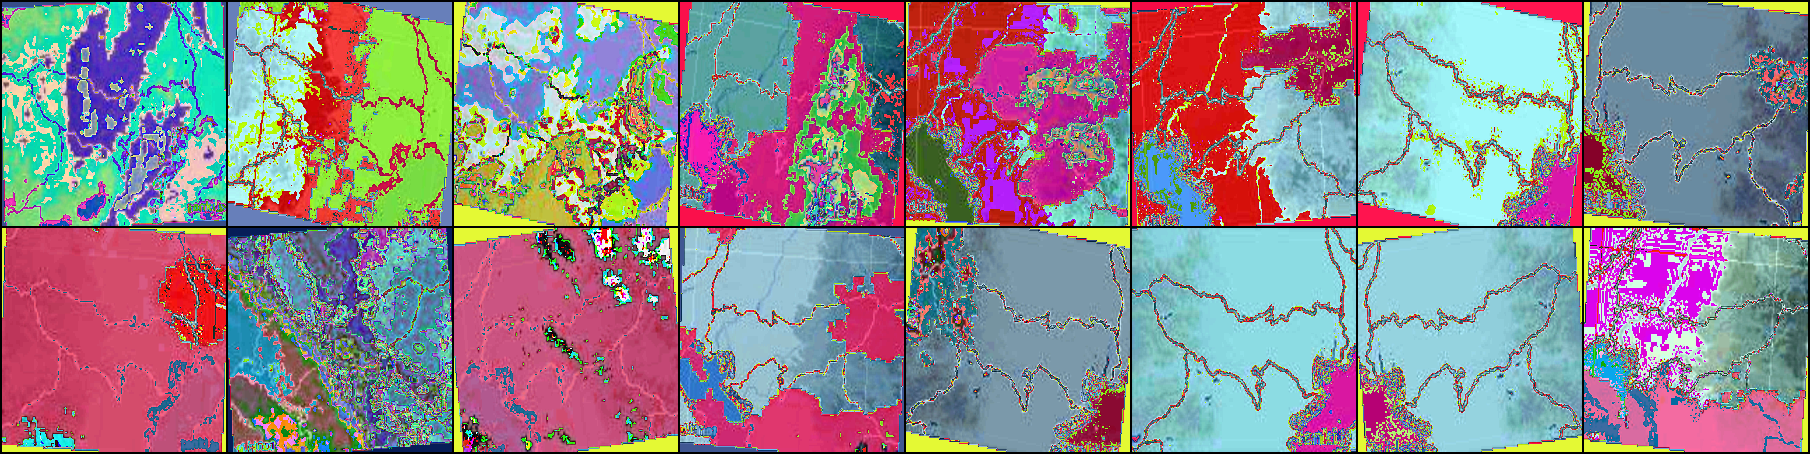

In [73]:
# ブロック 6
imgs, _ = next(iter(train_loader))
c, h, w = imgs[0].shape
print("ミニバッチサイズ：", len(imgs))
print("チャネル数：", c)
print("画像の高さ：", h)
print("画像の幅　：", w)
print(imgs.shape)

# グリッド上に並べて1枚の画像にする
img = torchvision.utils.make_grid(imgs)
img = transforms.functional.to_pil_image(img)
display(img)

In [104]:
# ブロック 7-2-2（以下3つの定数はMNISTの例、適宜書き換える）
INPUT_CHANNELS = 3 # MNISTのグレースケールの場合は1、カラーの場合は3
NUM_CLASSES = 3 # 分類するクラス数　MNISTの場合 10
FINAL_IMG_SIZE = 56 # MNIST 一辺の長さが28に対して2回MaxPool2dを通したら28→14→7

# CNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 画像の特徴を抽出するための層（畳み込み層、ReLU、MaxPooling）を定義
        self.features = nn.Sequential(
            # 最初の畳み込み層（INPUT_CHANNELSから64チャネルに変換）
            nn.Conv2d(in_channels=INPUT_CHANNELS, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),# ReLU活性化関数
            nn.MaxPool2d(kernel_size=2),# 最大プーリングを使用して画像サイズを半分にする
            
            # 2番目の畳み込み層（64チャネルから128チャネルに変換）
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),# ReLU活性化関数
            nn.MaxPool2d(kernel_size=2),# 最大プーリングを使用して画像サイズを半分にする
            
            # 3番目の畳み込み層（128チャネルから64チャネルに変換）
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True), # ReLU活性化関数
        )

        # 分類のための全結合層を定義
        self.classifier = nn.Sequential(
            # FINAL_IMG_SIZE*FINAL_IMG_SIZE*64の長さのベクトルから、NUM_CLASSESのベクトルに変換
            nn.Linear(in_features=FINAL_IMG_SIZE*FINAL_IMG_SIZE*64, out_features=56),
            nn.Dropout(0.4), # ドロップアウト（過学習を防ぐためにランダムにノードを無効化する）
            nn.Linear(in_features=56, out_features=NUM_CLASSES)
        )
        
    def forward(self, x):
        # 入力画像をfeaturesモジュールで処理
        output = self.features(x)
        # Flatten操作：2次元の特徴マップを1次元のベクトルに変換
        output = output.view(output.size(0), -1)
        # Flattenされたベクトルを分類層に通す
        output = self.classifier(output)
        return output

# モデルのインスタンスを作成し、GPU等のデバイスに移動
model = SimpleCNN().to(device)
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=56, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=56, out_features=3, bias=True)
  )
)

In [105]:
# ブロック 8
# 多クラス分類（2値分類も含む）のための損失関数の使用準備
criterion = nn.CrossEntropyLoss()

# AdamなどSGD以外の最適化関数を使用する場合
optimizer = OPTIMIZER(model.parameters(), lr=0.001 ,weight_decay=5e-4)

# SGDを使用する場合
#optimizer = OPTIMIZER(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [106]:
# mlflowのトラッキング開始
with mlflow.start_run():

    train_losses = []
    val_losses = []

    # ハイパーパラメータを記録
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("optimizer", OPTIMIZER)
    mlflow.log_param("epochs", EPOCHES)

    # RUN Timeの名前を設定
    mlflow.set_tag("mlflow.runName", RUN_NAME)  # runの名前をタグとして設定

    for epoch in range(EPOCHES):
        # モデルを訓練モードに設定
        model.train()
        total_loss = 0.0
        # 訓練データをミニバッチごとに処理
        for i, (images, labels) in enumerate(train_loader):
            # データをGPU等のデバイスに移動
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) # モデルに画像を入力し、予測値を取得
            loss = criterion(outputs, labels) # 損失を計算       
            optimizer.zero_grad() # 勾配を初期化
            loss.backward()  # バックプロパゲーションを実行        
            optimizer.step() # 重みの更新        
            total_loss += loss.item() # 現在のバッチの損失を累積値に追加

            # 平均訓練損失を計算
            avg_train_loss = total_loss / len(train_loader)
            train_losses.append(avg_train_loss)

        # モデルを評価モードに設定
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0  
            # 検証データをミニバッチごとに処理
            for images, labels in val_loader:
                # データをGPU等のデバイスに移動
                images, labels = images.to(device), labels.to(device)
                outputs = model(images) # モデルに画像を入力し、出力(予測値)を取得
                loss = criterion(outputs, labels) # 損失を計算         
                total_val_loss += loss.item() # 現在のバッチの損失を累積値に追加

        # 平均検証損失を計算
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # エポックごとの訓練と検証の損失を表示
        print(f"Epoch {epoch+1}/{EPOCHES}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
        mlflow.log_metric("Training Loss",avg_train_loss, step=epoch+1)
        mlflow.log_metric("Validation Loss",avg_val_loss, step=epoch+1)

    print('Finished Training')

Epoch 1/20, Training Loss: 6.702391296625137, Validation Loss: 0.8449206948280334
Epoch 2/20, Training Loss: 0.8980439901351929, Validation Loss: 0.6698185801506042
Epoch 3/20, Training Loss: 0.8822162449359894, Validation Loss: 0.6140387058258057
Epoch 4/20, Training Loss: 0.7097219824790955, Validation Loss: 0.6251946687698364
Epoch 5/20, Training Loss: 0.6289943903684616, Validation Loss: 0.3706093430519104
Epoch 6/20, Training Loss: 0.5744053050875664, Validation Loss: 0.41856348514556885
Epoch 7/20, Training Loss: 0.5157976374030113, Validation Loss: 0.5356266498565674
Epoch 8/20, Training Loss: 0.39397600293159485, Validation Loss: 0.49488475918769836
Epoch 9/20, Training Loss: 0.8259405642747879, Validation Loss: 0.6966326236724854
Epoch 10/20, Training Loss: 0.5068906545639038, Validation Loss: 0.3979993462562561
Epoch 11/20, Training Loss: 0.48586486279964447, Validation Loss: 0.40816980600357056
Epoch 12/20, Training Loss: 0.5293692424893379, Validation Loss: 0.44291189312934

In [107]:
# ブロック 11
device = torch.device('mps')
#device = torch.device('cpu') # 推論の場合はCPUでも高速に処理できる場合がある

model.eval()  # モデルを評価モードに設定。これにより、DropoutやBatchNormalizationなどの層が推論モードに切り替わる。

correct = 0  # 正しく分類されたサンプルの数を初期化
total = 0    # テストデータのサンプルの総数を初期化

# 勾配の計算を停止。評価時には勾配計算が不要なため、メモリ効率と速度を向上させる。
with torch.no_grad():
    for inputs, labels in test_loader:  # テストデータローダからミニバッチ単位でデータを取得
        inputs, labels = inputs.to(device), labels.to(device)  # データを現在のデバイス（CPU or GPU）に移動
        outputs = model(inputs)  # モデルを使って入力から出力を予測
        _, predicted = torch.max(outputs.data, 1)  # 各サンプルの最大値のインデックスを取得（予測されたクラスを取得）
        total += labels.size(0)  # ミニバッチのサンプル数をトータルカウントに追加
        correct += (predicted == labels).sum().item()  # 予測が正しい場合のカウントを加算

print(f"Accuracy on test set: {100 * correct / total}%")  # テストセットの正解率を計算して表示

Accuracy on test set: 92.85714285714286%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


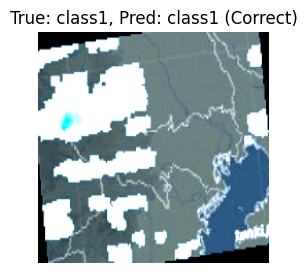

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


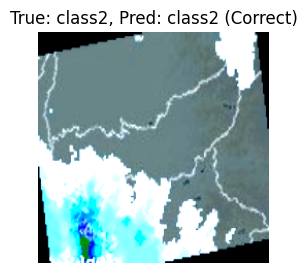

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


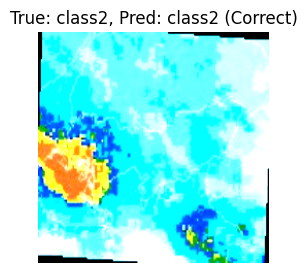

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


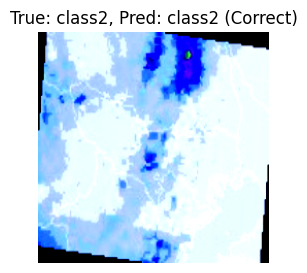

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


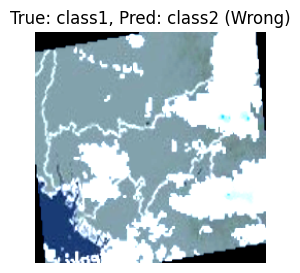

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


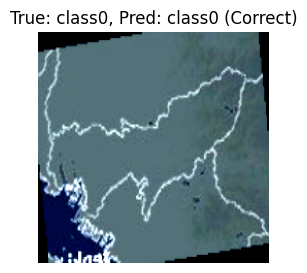

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


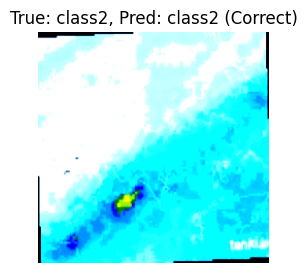

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


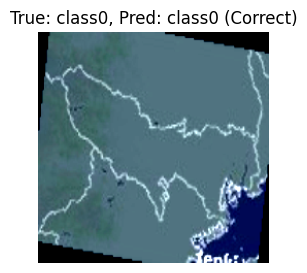

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


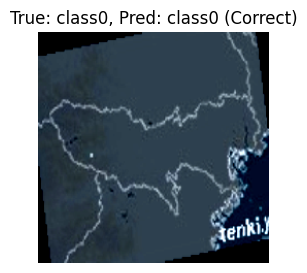

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


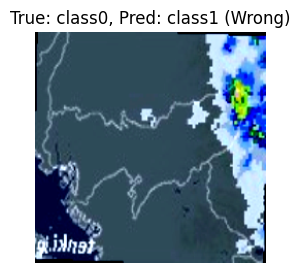

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


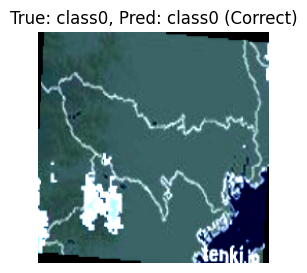

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


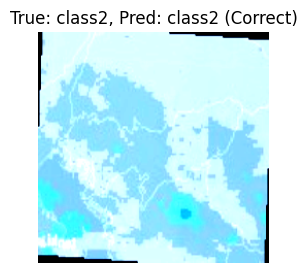

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


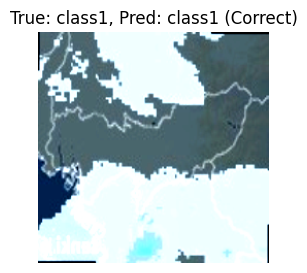

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


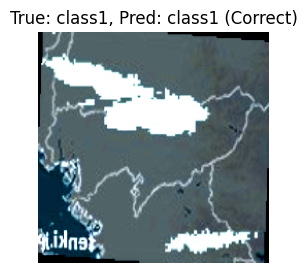

Accuracy on test set: 85.71428571428571%


In [95]:
# ブロック 12-2
import matplotlib.pyplot as plt
import numpy as np

# モデルを評価モードに設定。DropoutやBatchNormalizationなどの層が推論モードに切り替わる。
model.eval()
correct = 0  # 正しく分類されたサンプル数のカウントを初期化
total = 0    # テストデータのサンプルの総数を初期化

def imshow(img):
    # [0, 1]の範囲に変換
    img = img / 2 + 0.5
    npimg = img.numpy()  # PyTorchテンソルをnumpy配列に変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W)の順番を(H, W, C)に変更して表示
    plt.axis('off')  # 軸の目盛りを非表示にする

# 勾配の計算を停止。評価時には勾配計算が不要なため、メモリ効率と速度を向上させる。
with torch.no_grad():
    for inputs, labels in test_loader:  # テストデータローダからミニバッチ単位でデータを取得
        outputs = model(inputs.to(device))  # 入力をモデルに渡して、出力を取得
        _, predicted = torch.max(outputs.data, 1)  # 各サンプルの予測クラスのインデックスを取得
        total += labels.size(0)  # 現在のミニバッチのサンプル数をトータルカウントに追加
        correct += (predicted == labels.to(device)).sum().item()  # 正確に分類されたサンプル数をカウント
        
        # 推論結果の表示
        for i in range(inputs.size(0)):
            label = labels[i]          # 現在のサンプルの真のラベルを設定
            prediction = predicted[i]  # 現在のサンプルの予測ラベルを設定
            is_correct = "Correct" if label == prediction else "Wrong"  # 上の2つのラベルが一致するかどうかを評価
            
            plt.figure(figsize=(3,3))
            imshow(inputs[i])  # 画像を表示する関数を呼び出し
            plt.title(f"True: {dataset.classes[label]}, Pred: {dataset.classes[prediction]} ({is_correct})")  # タイトルに真のラベルと予測ラベルを表示
            plt.show()  # 画像とタイトルを表示

print(f"Accuracy on test set: {100 * correct / total}%")  # テストセットの全体での正解率を表示

In [88]:
model = model.to("cpu") # 推論時にCPUで計算する場合は、重みを保存する前に、モデルをCPU用に変換しておく
# モデルの重みを保存
torch.save(model.state_dict(), './Weights/weights.pth')